<a href="https://colab.research.google.com/github/desbaa32/Projet-M2BD-Index-Syst-me_multimodal_recommandation_produits/blob/master/Recommandation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SYSTÈME DE RECOMMANDATION MULTIMODAL POUR PRODUITS CHANEL:
   ***Création et Test du Système de Recommandation***

In [54]:

# Installation des packages nécessaires
print("Installation des packages...")
!pip install -q torch torchvision transformers pillow requests scikit-learn numpy pandas matplotlib seaborn

# Imports standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

# Imports pour le deep learning
import torch
import torch.nn as nn
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel, DistilBertTokenizer, DistilBertModel

# Imports pour la similarité et visualisation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import gc

print(" Tous les packages sont importés\n")

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Device utilisé : {device}\n")

Installation des packages...
 Tous les packages sont importés



## CHARGEMENT DES DONNÉES ET DESCRIPTEURS


In [55]:
# -----------------------------------------------------------------------------------
#  Chargement du dataset nettoyé

print(" Chargement du dataset...")

try:
    df_products = pd.read_csv('chanel_clean_dataset.csv')
    print(f" Dataset chargé depuis CSV : {df_products.shape}")
except:
    print("  Fichier CSV non trouvé. Chargement depuis HuggingFace...")
    from datasets import load_dataset
    dataset = load_dataset("DBQ/Chanel.Product.prices.Germany")
    df_products = pd.DataFrame(dataset['train'])

    # Sélection des colonnes importantes
    colonnes_importantes = ['category1_code', 'category2_code', 'title',
                            'imageurl', 'price_eur', 'product_code']
    df_products = df_products[colonnes_importantes]

    # Nettoyage basique
    import re
    def clean_text(text):
        if pd.isna(text) or text == 'n.a.':
            return ""
        text = text.lower()
        text = re.sub(r'[^\w\s\-&]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    df_products['title_cleaned'] = df_products['title'].apply(clean_text)
    df_products = df_products.drop_duplicates(subset=['product_code'])
    print(f" Dataset chargé et nettoyé : {df_products.shape}")

print(f"\n Aperçu du dataset :")
# display(df_products.head())
def show_info_dataset(df):
  print("__ Infos générales __")
  print(df.info())
  print("\n__ Colonnes __")
  print(df.columns.tolist())
  display(df_products.head())
show_info_dataset(df_products)

 Chargement du dataset...
 Dataset chargé depuis CSV : (1428, 7)

 Aperçu du dataset :
__ Infos générales __
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   category1_code  1428 non-null   object 
 1   category2_code  1428 non-null   object 
 2   product_code    1428 non-null   object 
 3   title           1428 non-null   object 
 4   imageurl        1428 non-null   object 
 5   price_eur       1428 non-null   float64
 6   title_cleaned   1382 non-null   object 
dtypes: float64(1), object(6)
memory usage: 78.2+ KB
None

__ Colonnes __
['category1_code', 'category2_code', 'product_code', 'title', 'imageurl', 'price_eur', 'title_cleaned']


,category1_code,category2_code,product_code,title,imageurl,price_eur,title_cleaned
0,FASHION,HANDBAGS,PAS4152B13455,Tweed & goldfarbenes Metall Schwarz Rosa & B...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5200.0,tweed & goldfarbenes metall schwarz rosa & bor...
1,FASHION,HANDBAGS,PA67085Y09953,n.a.,https://res.cloudinary.com/dwayrkp5z/image/fet...,5750.0,NaN
2,EYEWEAR,BLUE LIGHT GLASSES,PA71441,Schwarz,https://res.cloudinary.com/dwayrkp5z/image/fet...,420.0,schwarz
3,EYEWEAR,SUNGLASSES,PA71449,Silberfarben. Gläser: Braun Mit Verlauf,https://res.cloudinary.com/dwayrkp5z/image/fet...,580.0,silberfarben gläser braun mit verlauf
4,EYEWEAR,SUNGLASSES,PA71466,Blau & Rosa. Gläser: Grau Mit Verlauf,https://res.cloudinary.com/dwayrkp5z/image/fet...,480.0,blau & rosa gläser grau mit verlauf



###  Chargement des descripteurs



In [57]:

#_______ Chargement des descripteurs visuels et textuels

# Nombre de produits à utiliser pour le système de recommandation
MAX_PRODUCTS = 500

print(f" Nombre de produits pour la recommandation : {MAX_PRODUCTS}")
df_recommend = df_products.head(MAX_PRODUCTS).copy().reset_index(drop=True)

# Fonction pour charger les descripteurs sauvegardés
def load_descriptors_if_exists(filename, descriptor_name):
    """Charge les descripteurs depuis un fichier .npz"""
    try:
        data = np.load(filename)
        descriptors = data['descriptors']
        print(f" {descriptor_name} chargés : {descriptors.shape}")
        return descriptors
    except:
        print(f"  {descriptor_name} non trouvés dans {filename}")
        return None

# Tentative de chargement des descripteurs pré-calculés
print(" ..... Chargement des descripteurs visuels et textuels sauvegardés...\n")

visual_descriptors_loaded = load_descriptors_if_exists(
    'image_clip_descriptors.npz',
    'Descripteurs visuels (CLIP)'
)

text_descriptors_loaded = load_descriptors_if_exists(
    'text_descriptors_distilbert.npz',
    'Descripteurs textuels (DistilBERT)'
)


# EXTRACTION DES DESCRIPTEURS (SI NÉCESSAIRE)




# -----------------------------------------------------------------------------------
# 2.1 Configuration des transformations d'images
# -----------------------------------------------------------------------------------

IMG_SIZE = 224
eval_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

def load_and_preprocess_image(url, transform=eval_transforms):
    """Charge et prétraite une image depuis une URL"""
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        return transform(img)
    except:
        return None

# -----------------------------------------------------------------------------------
# Extraction des descripteurs visuels (CLIP)
if visual_descriptors_loaded is None:

    print(" descripteurs visuels Non chargés ...")

else:
    visual_descriptors = visual_descriptors_loaded
    valid_visual_indices = list(range(len(visual_descriptors)))
    # print(" Descripteurs visuels chargés")
# -----------------------------------------------------------------------------------
# Extraction des descripteurs textuels (DistilBER

if text_descriptors_loaded is None:
    print(" descripteurs visuels Non chargés ...")
else:
    text_descriptors = text_descriptors_loaded
    valid_text_indices = list(range(len(text_descriptors)))
    # print(" Descripteurs textuels chargés")

# -----------------------------------------------------------------------------------
# Synchronisation des indices
print("-"*30)
print(" Synchronisation des données(descripteurs valides pour les deux modalités)")


# Garder seulement les produits avec descripteurs valides pour les deux modalités
valid_indices = list(set(valid_visual_indices) & set(valid_text_indices))
print(f"{len(valid_indices)} produits avec descripteurs complets")

# Mise à jour du dataframe et des descripteurs
df_recommend = df_recommend.iloc[valid_indices].reset_index(drop=True)
visual_descriptors = visual_descriptors[[valid_visual_indices.index(i) for i in valid_indices]]
text_descriptors = text_descriptors[[valid_text_indices.index(i) for i in valid_indices]]

print(f"\n Dataset final :")
print(f"   - Produits : {len(df_recommend)}")
print(f"   - Descripteurs visuels : {visual_descriptors.shape}")
print(f"   - Descripteurs textuels : {text_descriptors.shape}")



 Nombre de produits pour la recommandation : 500
 ..... Chargement des descripteurs visuels et textuels sauvegardés...

 Descripteurs visuels (CLIP) chargés : (312, 512)
 Descripteurs textuels (DistilBERT) chargés : (500, 768)
------------------------------
 Synchronisation des données(descripteurs valides pour les deux modalités)
312 produits avec descripteurs complets

 Dataset final :
   - Produits : 312
   - Descripteurs visuels : (312, 512)
   - Descripteurs textuels : (312, 768)


## CRÉATION DU SYSTÈME DE RECOMMANDATION
  ***Classe du système de recommandation et initialisation***


In [58]:
from typing import List, Optional

# -----------------------------------------------------------------------------------
# Classe du système de recommandation
class MultimodalRecommendationSystem:
    """Système de recommandation multimodal pour produits Chanel"""

    def __init__(self, df, visual_descriptors, text_descriptors):
        """
        Initialise le système de recommandation

        Args:
            df: DataFrame avec les informations produits
            visual_descriptors: Descripteurs visuels (CLIP)
            text_descriptors: Descripteurs textuels (DistilBERT)
        """
        self.df = df.reset_index(drop=True)
        self.visual_descriptors = visual_descriptors
        self.text_descriptors = text_descriptors

        # Normalisation des descripteurs pour la similarité cosinus
        self.visual_descriptors_norm = normalize(visual_descriptors.astype(np.float32))
        self.text_descriptors_norm = normalize(text_descriptors.astype(np.float32))
        self.batch_size = 32
        self.max_text_length = 128

        print("="*25)
        print(" SYSTÈME INITIALISÉ")
        print("="*20)
        print(f"   • Nombre de produits    : {len(df)}")
        print(f"   • Dimensions visuelles  : {visual_descriptors.shape[1]}")
        print(f"   • Dimensions textuelles : {text_descriptors.shape[1]}")
        print(f"   • Catégories            : {df['category2_code'].nunique()}")
        print(f"   • Prix moyen            : {df['price_eur'].mean():.2f} €")


    def recommend_by_image(self, query_image_url, top_k=10, exclude_self=True):
        """
        Recommande des produits à partir d'une image

        Args:
            query_image_url: URL de l'image query
            top_k: Nombre de recommandations
            exclude_self: Exclure le produit query des résultats

        Returns:
            DataFrame des produits recommandés
        """
        # Vérifier si l'URL est dans la base
        is_in_db = query_image_url in self.df['imageurl'].values
        query_idx = None

        if is_in_db:
            query_idx = self.df[self.df['imageurl'] == query_image_url].index[0]
            query_descriptor = self.visual_descriptors_norm[query_idx:query_idx+1]
        else:
            # Extraction du descripteur de l'image externe
            query_descriptor = self._extract_external_visual_features(query_image_url)
            if query_descriptor is None:
                print(" Erreur : impossible d'extraire le descripteur de l'image")
                return None
            query_descriptor = normalize(query_descriptor.reshape(1, -1).astype(np.float32))

        # Calcul de similarité
        similarities = cosine_similarity(query_descriptor, self.visual_descriptors_norm)[0]

        # Exclure le produit query si nécessaire
        if exclude_self and query_idx is not None:
            similarities[query_idx] = -1

        # Top-k produits
        top_indices = similarities.argsort()[-top_k:][::-1]

        # Résultats
        results = self.df.iloc[top_indices].copy()
        results['similarity_score'] = similarities[top_indices]
        results['rank'] = range(1, len(results) + 1)

        return results

    def recommend_by_text(self, query_text, top_k=10):
        """
        Recommande des produits à partir d'une description textuelle

        Args:
            query_text: Texte de la query
            top_k: Nombre de recommandations

        Returns:
            DataFrame des produits recommandés
        """
        # Nettoyage du texte
        query_text_clean = self._clean_text(query_text)

        # Extraction du descripteur
        query_descriptor = self._extract_external_text_features(query_text_clean)
        if query_descriptor is None:
            print("Erreur : impossible d'extraire le descripteur du texte")
            return None

        # Normalisation
        query_descriptor = normalize(query_descriptor.reshape(1, -1).astype(np.float32))

        # Calcul de similarité
        similarities = cosine_similarity(query_descriptor, self.text_descriptors_norm)[0]

        # Top-k produits
        top_indices = similarities.argsort()[-top_k:][::-1]

        # Résultats
        results = self.df.iloc[top_indices].copy()
        results['similarity_score'] = similarities[top_indices]
        results['rank'] = range(1, len(results) + 1)

        return results

    def recommend_multimodal(self, query_image_url=None, query_text=None,
                            alpha=0.5, top_k=10, exclude_self=True):
        """
        Recommande des produits en combinant image et texte

        Args:
            query_image_url: URL de l'image query (optionnel)
            query_text: Texte de la query (optionnel)
            alpha: Poids de la similarité visuelle (1-alpha pour textuelle)
            top_k: Nombre de recommandations
            exclude_self: Exclure le produit query des résultats

        Returns:
            DataFrame des produits recommandés
        """
        if query_image_url is None and query_text is None:
            print("Erreur : au moins une modalité (image ou texte) doit être fournie")
            return None

        similarities = np.zeros(len(self.df), dtype=np.float32)
        query_idx = None

        # Composante visuelle
        if query_image_url is not None:
            is_in_db = query_image_url in self.df['imageurl'].values

            if is_in_db:
                query_idx = self.df[self.df['imageurl'] == query_image_url].index[0]
                query_visual = self.visual_descriptors_norm[query_idx:query_idx+1]
            else:
                query_visual = self._extract_external_visual_features(query_image_url)
                if query_visual is not None:
                    query_visual = normalize(query_visual.reshape(1, -1).astype(np.float32))

            if query_visual is not None:
                visual_sim = cosine_similarity(query_visual, self.visual_descriptors_norm)[0]
                similarities += alpha * visual_sim

        # Composante textuelle
        if query_text is not None:
            query_text_clean = self._clean_text(query_text)
            query_textual = self._extract_external_text_features(query_text_clean)

            if query_textual is not None:
                query_textual = normalize(query_textual.reshape(1, -1).astype(np.float32))
                text_sim = cosine_similarity(query_textual, self.text_descriptors_norm)[0]
                similarities += (1 - alpha) * text_sim

        # Exclure le produit query si nécessaire
        if exclude_self and query_idx is not None:
            similarities[query_idx] = -1

        # Top-k produits
        top_indices = similarities.argsort()[-top_k:][::-1]

        # Résultats
        results = self.df.iloc[top_indices].copy()
        results['similarity_score'] = similarities[top_indices]
        results['rank'] = range(1, len(results) + 1)

        return results

    def display_recommendations(self, results, query_info="", show_images=True):
        """Affiche les recommandations avec ou sans images"""
        if results is None or len(results) == 0:
            print(" Aucune recommandation disponible")
            return

        # Affichage textuel
        print("\n" + "="*20)
        print(f" RECOMMANDATIONS : {query_info}")


        for _, product in results.iterrows():
            rank = int(product['rank'])
            score = product['similarity_score']
            category = product['category2_code']
            price = product['price_eur']
            title = product['title'][:70]

            print(f"#{rank:2d} | Score: {score:.3f} | [{category}] {price:.0f}€")
            print(f"     {title}...")
            print()

        # Affichage visuel
        if show_images:
            n_products = len(results)
            n_cols = min(5, n_products)
            n_rows = (n_products + n_cols - 1) // n_cols

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 5*n_rows))
            if n_rows == 1:
                axes = axes.reshape(1, -1)
            elif n_cols == 1:
                axes = axes.reshape(-1, 1)

            for idx, (_, product) in enumerate(results.iterrows()):
                row = idx // n_cols
                col = idx % n_cols
                ax = axes[row, col]

                try:
                    response = requests.get(product['imageurl'], timeout=5)
                    img = Image.open(BytesIO(response.content))
                    ax.imshow(img)

                    title_text = f"#{int(product['rank'])} - {product['category2_code']}\n"
                    title_text += f"{product['price_eur']:.0f}€ | Score: {product['similarity_score']:.3f}"
                    ax.set_title(title_text, fontsize=9)

                except:
                    ax.text(0.5, 0.5, 'Image\nnon\ndisponible',
                           ha='center', va='center', fontsize=10)

                ax.axis('off')

            # Masquer les axes vides
            for idx in range(n_products, n_rows * n_cols):
                row = idx // n_cols
                col = idx % n_cols
                axes[row, col].axis('off')

            if query_info:
                fig.suptitle(f'Recommandations: {query_info}',
                            fontsize=14, fontweight='bold', y=0.98)

            plt.tight_layout()
            plt.show()

    # Méthodes auxiliaires
    def _clean_text(self, text):
        """Nettoie le texte"""
        import re
        if pd.isna(text):
            return ""
        text = text.lower()
        text = re.sub(r'[^\w\s\-&]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def _extract_external_visual_features(self, image_url):
        """Extrait les features CLIP d'une image externe"""
        # Chargement du modèle CLIP
        clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        clip_model.to(device)
        clip_model.eval()

        print("Modèle CLIP chargé")

        try:
            response = requests.get(image_url, timeout=5)
            img = Image.open(BytesIO(response.content)).convert('RGB')

            inputs = clip_processor(images=img, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                features = clip_model.get_image_features(**inputs)
                features = features.squeeze().cpu().numpy()

            return features
        except:
            return None


    def _extract_distilbert_features_batch(self, texts_batch: List[str]) -> Optional[np.ndarray]:
        """
        Extrait les features DistilBERT pour un batch de textes

        Args:
            texts_batch: Liste de textes à traiter

        Returns:
            Tableau numpy des embeddings ou None en cas d'erreur
        """
        print("Chargement du modèle DistilBERT pour l'extraction textuelle...")

        # Utiliser distilbert-base-uncased comme spécifié
        model_name = "distilbert-base-uncased"
        text_tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        text_model = DistilBertModel.from_pretrained(model_name)

        # Mettre le modèle en mode évaluation
        text_model.eval()
        text_model.to(device)

        print(" Modèle DistilBERT chargé avec succès")
        try:
            # Vérifier que le modèle est chargé
            # self._load_text_model()

            # Tokenization du batch
            inputs = text_tokenizer(
                texts_batch,
                padding='max_length',
                truncation=True,
                max_length=self.max_text_length,
                return_tensors='pt'
            )

            # Déplacer sur le device
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Extraction sans calcul de gradients
            with torch.no_grad():
                outputs = text_model(**inputs)
                # Utilisation du token [CLS] (première position)
                embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

            return embeddings.astype(np.float32)

        except Exception as e:
            print(f"     Erreur dans l'extraction batch : {e}")
            return None

    def _extract_external_text_features(self, text: str) -> Optional[np.ndarray]:
        """
        Extrait les caractéristiques textuelles d'un texte externe

        Args:
            text: Texte à analyser

        Returns:
            Vecteur d'embedding textuel (numpy array)
        """
        try:
            # Nettoyer le texte
            clean_text = self._clean_text(text)

            # Utiliser la méthode batch avec un seul texte
            text_embedding = self._extract_distilbert_features_batch([clean_text])

            if text_embedding is not None and len(text_embedding) > 0:
                return text_embedding[0]  # Retourner le premier (et unique) embedding
            else:
                return None

        except Exception as e:
            print(f"Erreur lors de l'extraction textuelle: {str(e)}")
            return None
# -----------------------------------------------------------------------------------
#  Initialisation du système

print(" Initialisation du système de recommandation...\n")
recommender = MultimodalRecommendationSystem(
    df_recommend,
    visual_descriptors,
    text_descriptors
)


 Initialisation du système de recommandation...

 SYSTÈME INITIALISÉ
   • Nombre de produits    : 312
   • Dimensions visuelles  : 512
   • Dimensions textuelles : 768
   • Catégories            : 35
   • Prix moyen            : 5466.53 €


## TESTS DU SYSTÈME DE RECOMMANDATION




------------------------------
TEST 1 : RECOMMANDATION PAR IMAGE
Produit query (index 5) :
   - Catégorie : SUNGLASSES
   - Prix      : 620.00€
   - Titre     : Schwarz. Gläser: Grau  Mit Verlauf...

 RECOMMANDATIONS : Image - SUNGLASSES
# 1 | Score: 0.941 | [SUNGLASSES] 550€
     Rosa & Weiß. Gläser: Rosa...

# 2 | Score: 0.920 | [COSTUME JEWELRY] 1550€
     Metall  Harz & Strass  Goldfarben  Gelb & Kristall...

# 3 | Score: 0.915 | [READY-TO-WEAR] 13200€
     Wolltweed & bestickte Baumwolle  Mehrfarbig...

# 4 | Score: 0.900 | [SUNGLASSES] 580€
     Silberfarben. Gläser: Braun  Mit Verlauf...

# 5 | Score: 0.897 | [COSTUME JEWELRY] 2000€
     Metall  Lammleder & Strass  Goldfarben  Schwarz & Kristall...

# 6 | Score: 0.896 | [COCO CRUSH] 6050€
     Steppmotiv  18 Karat BEIGEGOLD...

# 7 | Score: 0.892 | [HANDBAGS] 5400€
     Tweed  Pailletten & goldfarbenes Metall  Schwarz & Weiß...

# 8 | Score: 0.890 | [READY-TO-WEAR] 2650€
     Alpaka & Mischfasern  Weiß...

# 9 | Score: 0.888 | [

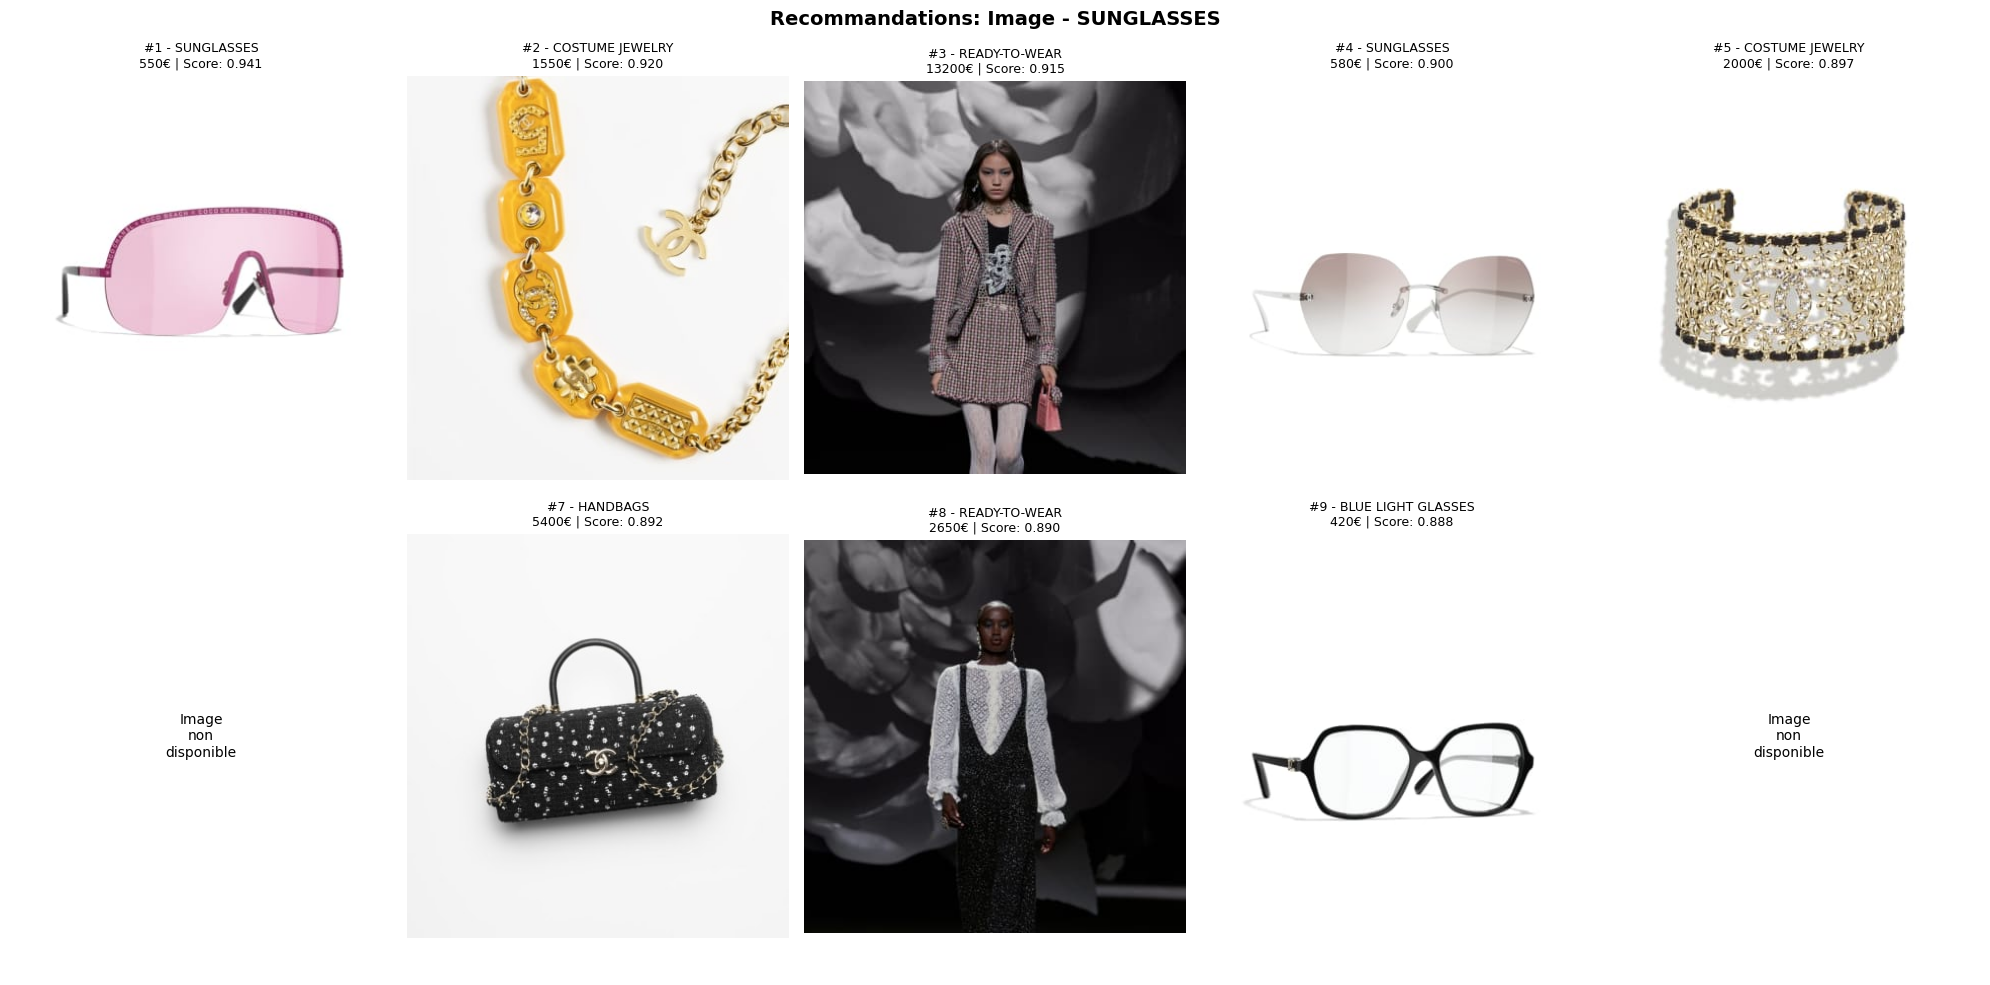

In [59]:
# -----------------------------------------------------------------------------------
#Test : Recommandation par image

print("-"*30)
print("TEST 1 : RECOMMANDATION PAR IMAGE")


# Sélection d'un produit test
test_idx = 5
test_product = df_recommend.iloc[test_idx]
test_image_url = test_product['imageurl']

print(f"Produit query (index {test_idx}) :")
print(f"   - Catégorie : {test_product['category2_code']}")
print(f"   - Prix      : {test_product['price_eur']:.2f}€")
print(f"   - Titre     : {test_product['title'][:60]}...")

# Recommandations
recommendations_image = recommender.recommend_by_image(
    test_image_url,
    top_k=10,
    exclude_self=True
)

# Affichage
recommender.display_recommendations(
    recommendations_image,
    query_info=f"Image - {test_product['category2_code']}",
    show_images=True
)



------------------------------
 TEST 2 : RECOMMANDATION PAR TEXTE

 Query : 'elegant women perfume with floral notes'

Chargement du modèle DistilBERT pour l'extraction textuelle...
 Modèle DistilBERT chargé avec succès

 RECOMMANDATIONS : Texte - 'elegant women perfume with floral notes'
# 1 | Score: 0.970 | [MEN] 39€
     DEODORANT STICK...

# 2 | Score: 0.970 | [MEN] 39€
     DEODORANT STICK...

# 3 | Score: 0.970 | [MEN] 39€
     DEODORANT STICK...

# 4 | Score: 0.967 | [N°5] 4350€
     18 Karat BEIGEGOLD  Diamanten...

# 5 | Score: 0.967 | [N°5] 9050€
     18 Karat BEIGEGOLD  Diamanten...

# 6 | Score: 0.967 | [WOMEN] 118€
     EAU DE TOILETTE TWIST AND SPRAY...

# 7 | Score: 0.966 | [WOMEN] 136€
     EAU DE PARFUM TWIST AND SPRAY...

# 8 | Score: 0.966 | [BRUSHES AND ACCESSORIES] 40€
     HIGHLIGHTER-PINSEL...

# 9 | Score: 0.964 | [RINGS] 9500€
     18 Karat Gelbgold  Diamant...

#10 | Score: 0.963 | [BROOCHES] 27100€
     18 Karat Gelbgold  Diamanten...



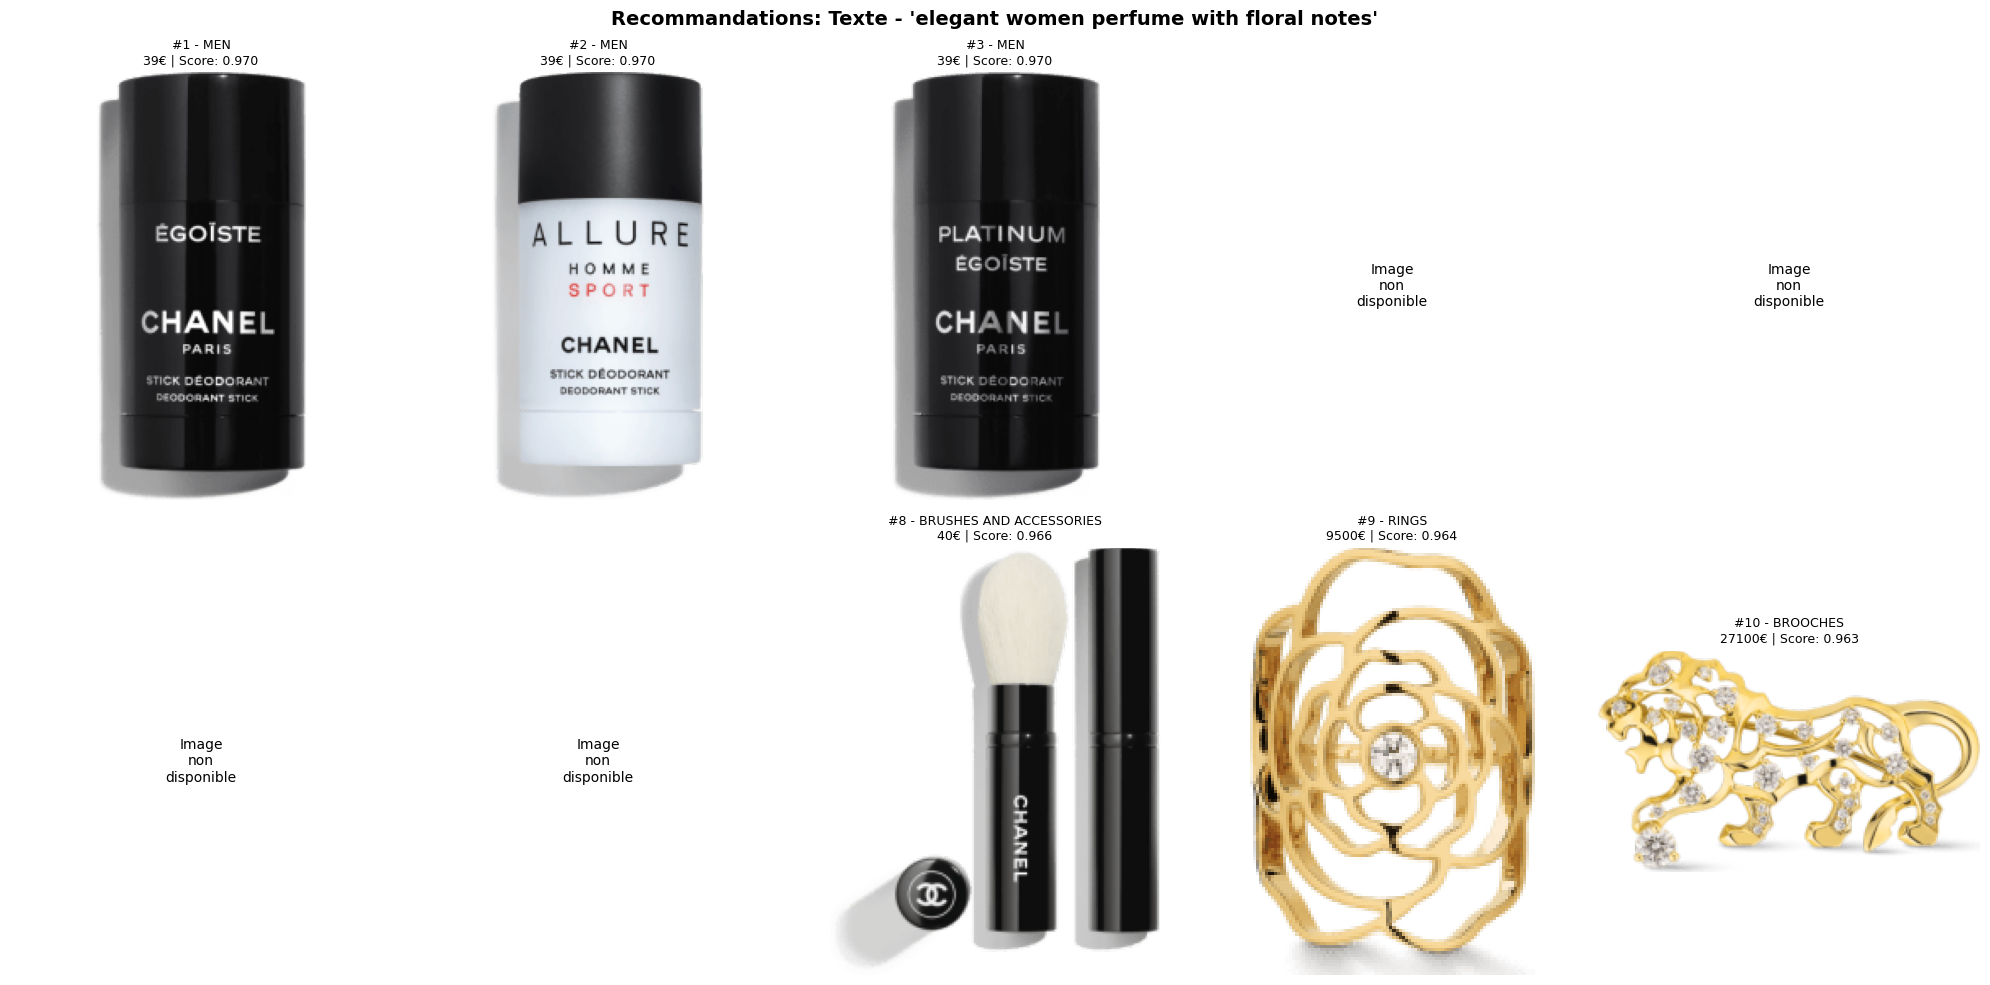


 Query : 'slim wallet with logo for menbijoux or diamants précieuxklassischer roter lippenstift matte optik'

Chargement du modèle DistilBERT pour l'extraction textuelle...
 Modèle DistilBERT chargé avec succès

 RECOMMANDATIONS : Texte - 'slim wallet with logo for menbijoux or diamants précieuxklassischer roter lippenstift matte optik'
# 1 | Score: 0.937 | [COCO CRUSH] 4060€
     Steppmotiv  Mini-Modell  18 Karat BEIGEGOLD  Diamanten...

# 2 | Score: 0.930 | [MEN] 160€
     PARFUM LIMITIERTE EDITION 100 ML...

# 3 | Score: 0.927 | [SMALL LEATHER GOODS] 1340€
     Kalbsleder in Vintage-Optik & goldfarbenes Metall  Schwarz...

# 4 | Score: 0.927 | [HANDBAGS] 11100€
     Kalbsleder in Vintage-Optik & goldfarbenes Metall  Schwarz...

# 5 | Score: 0.925 | [SMALL LEATHER GOODS] 2900€
     Glänzendes Kalbsleder in Vintage-Optik & goldfarbenes Metall  Weiß...

# 6 | Score: 0.924 | [COCO CRUSH] 9100€
     Steppmotiv  großes Modell  18 Karat BEIGEGOLD  Diamanten...

# 7 | Score: 0.923 | [COCO 

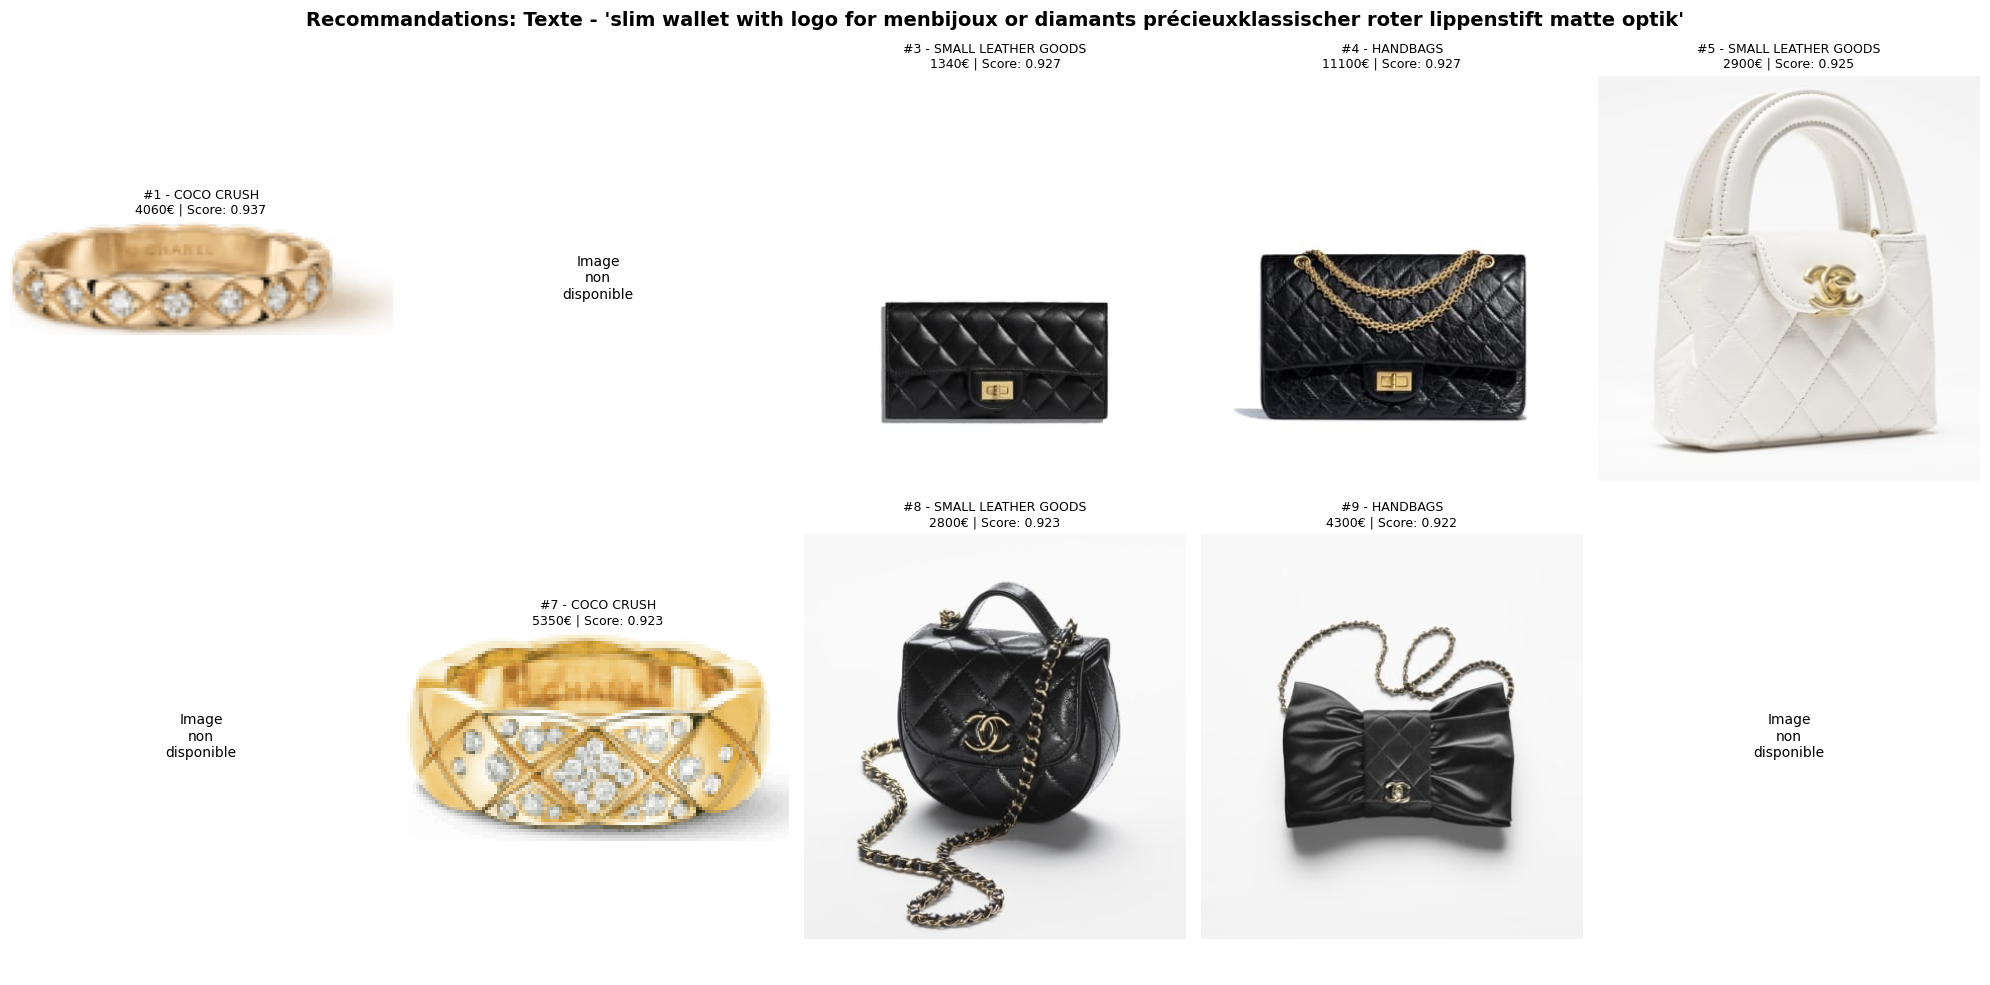

In [60]:

# -----------------------------------------------------------------------------------
#  Test : Recommandation par texte
print("\n" + "-"*30)
print(" TEST 2 : RECOMMANDATION PAR TEXTE")

test_queries = [
    "elegant women perfume with floral notes",
    "slim wallet with logo for men"
    "bijoux or diamants précieux"
    "klassischer roter lippenstift matte optik",
]

for query in test_queries[:4]:  # Tester 2 requêtes
    print(f"\n Query : '{query}'\n")

    recommendations_text = recommender.recommend_by_text(query, top_k=10)

    if recommendations_text is not None:
        recommender.display_recommendations(
            recommendations_text,
            query_info=f"Texte - '{query}'",
            show_images=True
        )




------------------------------
🔄 TEST 3 : RECOMMANDATION MULTIMODALE (Image + Texte)
 Query multimodale :
   -Image : Produit index 10
   -Texte : 'elegant luxe '
   -Alpha : 0.5 (équilibré)
Chargement du modèle DistilBERT pour l'extraction textuelle...
 Modèle DistilBERT chargé avec succès

 RECOMMANDATIONS : Multimodal - Image + 'elegant luxe '
# 1 | Score: 0.902 | [SUNGLASSES] 440€
     Silberfarben. Gläser: Bordeaux...

# 2 | Score: 0.889 | [MEN] 39€
     DEODORANT STICK...

# 3 | Score: 0.881 | [EYEGLASSES] 460€
     Goldfarben...

# 4 | Score: 0.876 | [MEN] 240€
     LES EXCLUSIFS DE CHANEL - EXTRAIT...

# 5 | Score: 0.869 | [WOMEN] 120€
     EXTRAIT FLAKON...

# 6 | Score: 0.864 | [BLUE LIGHT GLASSES] 320€
     Hellrosa. Gläser: Transparent...

# 7 | Score: 0.862 | [EYEGLASSES] 430€
     Schwarz...

# 8 | Score: 0.862 | [COCO CRUSH] 5350€
     Steppmotiv  kleines Modell  18 Karat Gelbgold  Diamanten...

# 9 | Score: 0.861 | [WOMEN] 116€
     PARFUM TASCHENZERSTÄUBER...

#10 | S

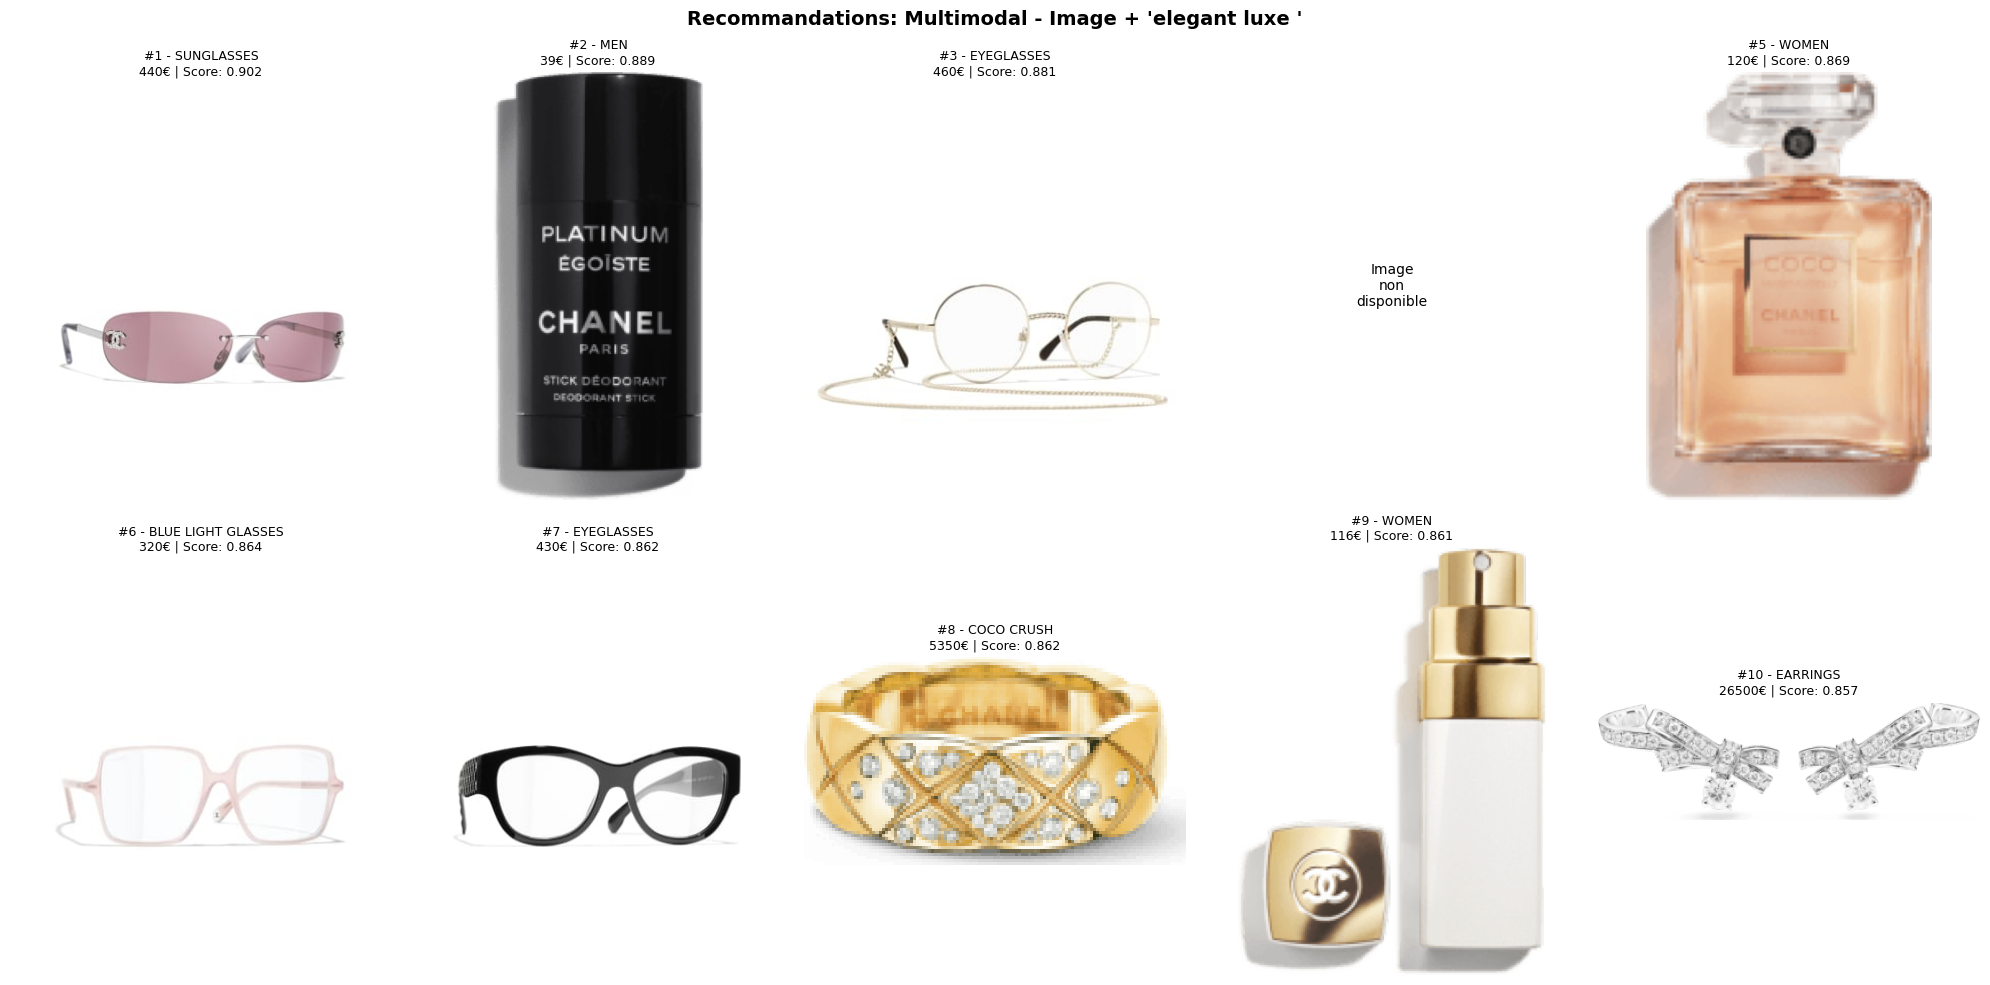

In [61]:
# -----------------------------------------------------------------------------------
# Test : Recommandation multimodale
print("\n" + "-"*30)
print("🔄 TEST 3 : RECOMMANDATION MULTIMODALE (Image + Texte)")

test_idx_multi = 10
test_product_multi = df_recommend.iloc[test_idx_multi]
test_image_url_multi = test_product_multi['imageurl']
test_text = "elegant luxe "

print(f" Query multimodale :")
print(f"   -Image : Produit index {test_idx_multi}")
print(f"   -Texte : '{test_text}'")
print(f"   -Alpha : 0.5 (équilibré)")

recommendations_multi = recommender.recommend_multimodal(
    query_image_url=test_image_url_multi,
    query_text=test_text,
    alpha=0.5,
    top_k=10,
    exclude_self=True
)

recommender.display_recommendations(
    recommendations_multi,
    query_info=f"Multimodal - Image + '{test_text}'",
    show_images=True
)

In [62]:
print("SAUVEGARDE DU SYSTÈME")

# Sauvegarde des descripteurs
np.save('visual_descriptors_recom.npy', visual_descriptors)
np.save('text_descriptors_recom.npy', text_descriptors)
df_recommend.to_csv('products_database_recom.csv', index=False)

SAUVEGARDE DU SYSTÈME


## Création d'une Interface avec Streamlit

####
**Important**: Pour exécuter cette application Streamlit localement, vous devrez télécharger le fichier `app.py` généré ci-dessous sur votre machine locale et l'exécuter depuis votre terminal.

In [63]:
!pip install -q streamlit
print("Streamlit installé.")

Streamlit installé.


In [64]:
%%writefile app.py
from typing import List, Optional
import streamlit as st
import pandas as pd
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import torch
import torch.nn as nn
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel, DistilBertTokenizer, DistilBertModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import re

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------------------------------------
# Classe du système de recommandation
# -----------------------------------------------------------------------------------
class MultimodalRecommendationSystem:
    def __init__(self, df, visual_descriptors, text_descriptors):
        self.df = df.reset_index(drop=True)
        self.visual_descriptors = visual_descriptors
        self.text_descriptors = text_descriptors
        self.visual_descriptors_norm = normalize(visual_descriptors.astype(np.float32))
        self.text_descriptors_norm = normalize(text_descriptors.astype(np.float32))
        self.batch_size = 32
        self.max_text_length = 128

        self.clip_model = None
        self.clip_processor = None
        self.text_tokenizer = None
        self.text_model = None

    def _load_clip_model(self):
        if self.clip_model is None:
            self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
            self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
            self.clip_model.to(device)
            self.clip_model.eval()

    def _load_distilbert_model(self):
        if self.text_model is None:
            model_name = "distilbert-base-uncased"
            self.text_tokenizer = DistilBertTokenizer.from_pretrained(model_name)
            self.text_model = DistilBertModel.from_pretrained(model_name)
            self.text_model.eval()
            self.text_model.to(device)

    def _clean_text(self, text):
        if pd.isna(text):
            return ""
        text = text.lower()
        text = re.sub(r'[^\w\s\-&]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def _extract_external_visual_features(self, image_url):
        self._load_clip_model()
        try:
            response = requests.get(image_url, timeout=5)
            img = Image.open(BytesIO(response.content)).convert('RGB')

            inputs = self.clip_processor(images=img, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                features = self.clip_model.get_image_features(**inputs)
                features = features.squeeze().cpu().numpy()
            return features
        except Exception as e:
            st.error(f"Erreur lors de l'extraction de l'image : {e}")
            return None

    def _extract_distilbert_features_batch(self, texts_batch: list) -> Optional[np.ndarray]:
        self._load_distilbert_model()
        try:
            inputs = self.text_tokenizer(
                texts_batch,
                padding='max_length',
                truncation=True,
                max_length=self.max_text_length,
                return_tensors='pt'
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.text_model(**inputs)
                embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            return embeddings.astype(np.float32)

        except Exception as e:
            st.error(f"Erreur dans l'extraction batch : {e}")
            return None

    def _extract_external_text_features(self, text: str) -> Optional[np.ndarray]:
        clean_text = self._clean_text(text)
        text_embedding = self._extract_distilbert_features_batch([clean_text])
        if text_embedding is not None and len(text_embedding) > 0:
            return text_embedding[0]
        else:
            return None

    def recommend_by_image(self, query_image_url, top_k=10, exclude_self=True):
        is_in_db = query_image_url in self.df['imageurl'].values
        query_idx = None

        if is_in_db:
            query_idx = self.df[self.df['imageurl'] == query_image_url].index[0]
            query_descriptor = self.visual_descriptors_norm[query_idx:query_idx+1]
        else:
            query_descriptor = self._extract_external_visual_features(query_image_url)
            if query_descriptor is None:
                return None
            query_descriptor = normalize(query_descriptor.reshape(1, -1).astype(np.float32))

        similarities = cosine_similarity(query_descriptor, self.visual_descriptors_norm)[0]

        if exclude_self and query_idx is not None:
            similarities[query_idx] = -1

        top_indices = similarities.argsort()[-top_k:][::-1]
        results = self.df.iloc[top_indices].copy()
        results['similarity_score'] = similarities[top_indices]
        results['rank'] = range(1, len(results) + 1)
        return results

    def recommend_by_text(self, query_text, top_k=10):
        query_text_clean = self._clean_text(query_text)
        query_descriptor = self._extract_external_text_features(query_text_clean)
        if query_descriptor is None:
            return None

        query_descriptor = normalize(query_descriptor.reshape(1, -1).astype(np.float32))
        similarities = cosine_similarity(query_descriptor, self.text_descriptors_norm)[0]
        top_indices = similarities.argsort()[-top_k:][::-1]

        results = self.df.iloc[top_indices].copy()
        results['similarity_score'] = similarities[top_indices]
        results['rank'] = range(1, len(results) + 1)
        return results

    def recommend_multimodal(self, query_image_url=None, query_text=None,
                            alpha=0.5, top_k=10, exclude_self=True):
        if query_image_url is None and query_text is None:
            st.error("Erreur : au moins une modalité (image ou texte) doit être fournie")
            return None

        similarities = np.zeros(len(self.df), dtype=np.float32)
        query_idx = None

        if query_image_url is not None:
            is_in_db = query_image_url in self.df['imageurl'].values

            if is_in_db:
                query_idx = self.df[self.df['imageurl'] == query_image_url].index[0]
                query_visual = self.visual_descriptors_norm[query_idx:query_idx+1]
            else:
                query_visual = self._extract_external_visual_features(query_image_url)
                if query_visual is not None:
                    query_visual = normalize(query_visual.reshape(1, -1).astype(np.float32))

            if query_visual is not None:
                visual_sim = cosine_similarity(query_visual, self.visual_descriptors_norm)[0]
                similarities += alpha * visual_sim

        if query_text is not None:
            query_text_clean = self._clean_text(query_text)
            query_textual = self._extract_external_text_features(query_text_clean)

            if query_textual is not None:
                query_textual = normalize(query_textual.reshape(1, -1).astype(np.float32))
                text_sim = cosine_similarity(query_textual, self.text_descriptors_norm)[0]
                similarities += (1 - alpha) * text_sim

        if exclude_self and query_idx is not None:
            similarities[query_idx] = -1

        top_indices = similarities.argsort()[-top_k:][::-1]
        results = self.df.iloc[top_indices].copy()
        results['similarity_score'] = similarities[top_indices]
        results['rank'] = range(1, len(results) + 1)
        return results


# -----------------------------------------------------------------------------------
# Chargement des données et initialisation du système de recommandation
# -----------------------------------------------------------------------------------
@st.cache_resource
def load_data_and_recommender():
    try:
        df_products_recom = pd.read_csv('products_database_recom.csv')
        visual_descriptors_recom = np.load('visual_descriptors_recom.npy')
        text_descriptors_recom = np.load('text_descriptors_recom.npy')

        recommender_system = MultimodalRecommendationSystem(
            df_products_recom,
            visual_descriptors_recom,
            text_descriptors_recom
        )
        return df_products_recom, recommender_system
    except Exception as e:
        st.error(f"Erreur lors du chargement des données ou du système de recommandation : {e}")
        st.stop()

df_products, recommender = load_data_and_recommender()


# -----------------------------------------------------------------------------------
# Interface Streamlit
# -----------------------------------------------------------------------------------
st.set_page_config(layout="wide", page_title="Chanel Recommender")

st.title(" Système de Recommandation Multimodal pour Produits Chanel")
st.write("Recommandations basées sur des requêtes textuelles, des images ou une combinaison des deux.")

# Sidebar pour les paramètres
st.sidebar.header("Paramètres de Recommandation")
selected_mode = st.sidebar.radio("Choisissez un mode de recherche",
                                 ("Texte", "Image", "Multimodal (Texte + Image)"))
top_k = st.sidebar.slider("Nombre de recommandations à afficher", 1, 20, 5)


results = None
query_info = ""

if selected_mode == "Texte":
    st.header("Recommandation par Texte")
    query_text = st.text_input("Entrez une description de produit (ex: 'sac en cuir noir élégant')", "sac en cuir noir élégant")
    if st.button("Recommander par Texte"):
        if query_text:
            with st.spinner("Recherche de recommandations textuelles..."):
                results = recommender.recommend_by_text(query_text, top_k=top_k)
                query_info = f"Texte: '{query_text}'"
        else:
            st.warning("Veuillez entrer un texte pour la recherche.")

elif selected_mode == "Image":
    st.header("Recommandation par Image")
    image_url_option = st.radio("Source de l'image", ("Sélectionner une image existante", "URL d'une image externe"))

    query_image_url = None
    if image_url_option == "Sélectionner une image existante":
        st.subheader("Choisissez un produit de la base de données")
        product_titles = df_products['title'].tolist()
        selected_title = st.selectbox("Produit", product_titles)
        if selected_title:
            query_image_url = df_products[df_products['title'] == selected_title]['imageurl'].iloc[0]
            st.image(query_image_url, caption=selected_title, width=200)
    else:
        query_image_url = st.text_input("Entrez l'URL d'une image (ex: https://example.com/image.jpg)")
        if query_image_url:
            try:
                response = requests.get(query_image_url, timeout=5)
                img = Image.open(BytesIO(response.content))
                st.image(img, caption='Image externe', width=200)
            except Exception:
                st.error("URL d'image invalide ou impossible de charger l'image.")
                query_image_url = None

    if st.button("Recommander par Image"):
        if query_image_url:
            with st.spinner("Recherche de recommandations visuelles..."):
                results = recommender.recommend_by_image(query_image_url, top_k=top_k)
                query_info = f"Image: '{query_image_url[:50]}...'"
        else:
            st.warning("Veuillez fournir une image pour la recherche.")

elif selected_mode == "Multimodal (Texte + Image)":
    st.header("Recommandation Multimodale")

    # Entrée texte
    query_text_multi = st.text_input("Entrez une description (ex: 'bijou or')", "bijou en or")

    # Entrée image
    st.subheader("Sélectionnez une image (facultatif)")
    image_url_option_multi = st.radio("Source de l'image pour multimodal", ("Aucune image", "Sélectionner une image existante", "URL d'une image externe"))
    query_image_url_multi = None

    if image_url_option_multi == "Sélectionner une image existante":
        product_titles_multi = df_products['title'].tolist()
        selected_title_multi = st.selectbox("Produit (Image)", product_titles_multi)
        if selected_title_multi:
            query_image_url_multi = df_products[df_products['title'] == selected_title_multi]['imageurl'].iloc[0]
            st.image(query_image_url_multi, caption=selected_title_multi, width=150)
    elif image_url_option_multi == "URL d'une image externe":
        query_image_url_multi = st.text_input("URL d'image (multimodal)")
        if query_image_url_multi:
            try:
                response = requests.get(query_image_url_multi, timeout=5)
                img = Image.open(BytesIO(response.content))
                st.image(img, caption='Image externe (multimodal)', width=150)
            except Exception:
                st.error("URL d'image invalide ou impossible de charger l'image.")
                query_image_url_multi = None

    alpha = st.sidebar.slider("Poids de l'image (alpha)", 0.0, 1.0, 0.5)

    if st.button("Recommander en Multimodal"):
        if not query_text_multi and not query_image_url_multi:
            st.warning("Veuillez fournir au moins un texte ou une image pour la recherche multimodale.")
        else:
            with st.spinner("Recherche de recommandations multimodales..."):
                results = recommender.recommend_multimodal(
                    query_image_url=query_image_url_multi,
                    query_text=query_text_multi,
                    alpha=alpha,
                    top_k=top_k
                )
                query_info = f"Multimodal - Texte: '{query_text_multi}', Image: '{'Oui' if query_image_url_multi else 'Non'}'"

# Affichage des résultats
st.markdown("--- ")
st.header(" Résultats de la Recommandation")

if results is not None and not results.empty:
    st.subheader(f"Top {len(results)} Recommandations pour {query_info}")

    # Créer une disposition en grille pour les produits
    cols = st.columns(min(len(results), 5)) # Afficher max 5 colonnes

    for i, (idx, product) in enumerate(results.iterrows()):
        with cols[i % 5]: # Utilise le modulo pour enrouler sur les colonnes
            st.markdown(f"**Rank {int(product['rank'])}**")
            st.markdown(f"**Score: {product['similarity_score']:.3f}**")
            st.markdown(f"**{product['category2_code']}**")
            st.markdown(f"{product['price_eur']:.0f}€")
            st.caption(product['title'])

            try:
                response = requests.get(product['imageurl'], timeout=5)
                img = Image.open(BytesIO(response.content))
                st.image(img, use_column_width=True)
            except Exception:
                st.warning("Image non disponible")
else:
    st.info("Aucune recommandation pour le moment. Essayez une autre recherche !")



Writing app.py


## Lancer Streamlit avec pyngrok

Exécuter l'application `app.py` à l'aide de Streamlit et `pyngrok` pour obtenir une URL publique dans Colab.


In [65]:
!pip install -q pyngrok
print("pyngrok installé.")

pyngrok installé.


In [66]:
import os
from subprocess import Popen, DEVNULL
from pyngrok import ngrok, conf
import getpass

# 1. Start Streamlit app in the background
print("Démarrage de l'application Streamlit en arrière-plan...")
# Use --server.enableCORS false and --server.enableXsrfProtection false for Colab
streamlit_process = Popen(["streamlit", "run", "app.py", "--server.port", "8501", "--server.enableCORS", "false", "--server.enableXsrfProtection", "false"], stdout=DEVNULL, stderr=DEVNULL)
print("Application Streamlit démarrée sur le port 8501.")

# 2. Authenticate ngrok
print("\nConfiguration de ngrok...")
# Get ngrok authtoken from user input
# Make sure you have an ngrok authtoken. You can get one from https://dashboard.ngrok.com/get-started/your-authtoken
ngrok_authtoken = getpass.getpass("Entrez votre authtoken ngrok (il ne sera pas affiché) : ")

try:
    ngrok.set_auth_token(ngrok_authtoken)
    print("Authtoken ngrok configuré avec succès.")
except Exception as e:
    print(f"Erreur lors de la configuration de l'authtoken ngrok: {e}")
    print("Veuillez vous assurer que l'authtoken est valide.")
    # Optionally, exit or handle the error more gracefully

# 3. Create ngrok tunnel
print("Création du tunnel ngrok...")
public_url = ngrok.connect(8501)
print(f"\n Votre application Streamlit est accessible publiquement à l'adresse : {public_url}")
print("Appuyez sur Ctrl+C dans cette cellule pour fermer le tunnel et l'application Streamlit.")

Démarrage de l'application Streamlit en arrière-plan...
Application Streamlit démarrée sur le port 8501.

Configuration de ngrok...
Entrez votre authtoken ngrok (il ne sera pas affiché) : ··········
Authtoken ngrok configuré avec succès.
Création du tunnel ngrok...

 Votre application Streamlit est accessible publiquement à l'adresse : NgrokTunnel: "https://77a4e126a456.ngrok-free.app" -> "http://localhost:8501"
Appuyez sur Ctrl+C dans cette cellule pour fermer le tunnel et l'application Streamlit.
